# State Space Model of Learning

This notebook demonstrates usage of the framework for the state space model of learning problem. Additionally, it is used to create Fig. 1 in section IV.A.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli as bern
import seaborn as sns
sns.set(rc={'image.cmap': 'jet'},font_scale=2)
%matplotlib inline

import sys
sys.path
sys.path.append('../python/')
from ssml import ssml

# Temporary to avoid the "if self._edgecolors == str('face')" FutureWarning
import warnings
warnings.filterwarnings('ignore')

## *1 - The Model*

### Learning State (Unobservable)
Consider a state space model for the process of learning to do a task. Multiple trials of the task are conducted, with each task resulting in success or failure. At first, the learning state is $0$ - there is nothing known about correctly solving the task. As time goes on, the learning state evolves as a random walk, implying that regardless of success or failure in a given trial, the subject's knowledge of how to complete the task (the learning state) may increase or decrease. We do assume that on average, the learning state evolves with time. Thus, we model the learning state at the $n^{th}$ trial as:

$$
X_n = \gamma + \phi X_{n-1} + V_n
$$

where $\gamma$ is the **learning rate** (how much do we expect the state to increase on average), $\phi$ is the **forgetting factor** (how much does the previous state affect the current state), and $V_n \sim \mathcal{N}(0,\sigma_V^2)$ is a Gaussian random vector to account for the uncertainty of how the state will evolve.

Below we use this model to create synthetic data representing the learning state over $N=25$ trials. It is assumed that we *cannot* observe this state. This synthesized data will be the ground truth that we will be estimating later on.

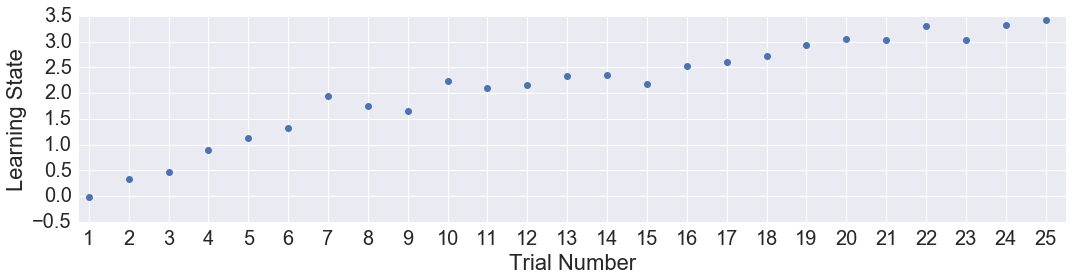

In [2]:
N = 25           # Number of trials
gamma = 0.1      # Learning rate
phi = 0.99       # Forgetting factor
sigv = 0.03      # Variance of zero mean Gaussian vector for learning state random walk
V = np.sqrt(sigv)*np.random.randn(N) # Gaussian vector for learning state random walk
X = np.zeros((N,))
X[0] = gamma + V[0]
for n in range(1,len(X)):
    X[n] = gamma + phi*X[n-1] + V[n]

plt.figure(figsize=(15,4))
plt.plot(range(1,N+1),X,'o')
plt.xlim(0.75,N+0.5)
plt.xticks(range(1,N+1))
plt.xlabel('Trial Number')
plt.ylabel('Learning State')
plt.tight_layout();

After synthesizing the learning state, we can use it to create the processes that will be observable, following the assumption that there is an evolving learning state representing how much the subject has learned, and it is the state which is determining (to a certain extent) the subject's actions for a given trial. In other words, the model is not setup such that the success of a trial determines the learning state, but rather the learning state determines the probability of success in a trial (amongst other things). It all starts from the learning state!

### Reaction Time (Continuous Observation)

Amongst said "other things" is reaction time. With each trial, the time it takes for the subject to react and make a decision is observed (observed as a positive real number). As explained above, the reaction time for a given trial is modeled as a function of the learning state. More specifically, there will be an inverse relationship with the learning state, because we can assume that the more the subject has learned about the task, the less time it takes the subject to make a decision. Thus, the log of the reaction time on the $n^{th}$ trial is modeled by:

$$
Q_n = \delta + hX_n + G_n
$$

where $\delta$ is the expected reaction time when the subject knows nothing (remember, learning state starts at 0), $h$ is a negative factor that determines the extent of the effect of the learning state on reaction time, and $G_n \sim \mathcal{N}(0,\sigma_G^2)$ is a Gaussian random vector to account for the assumption that there is not a strictly deterministic relationship between learning state and behavior.

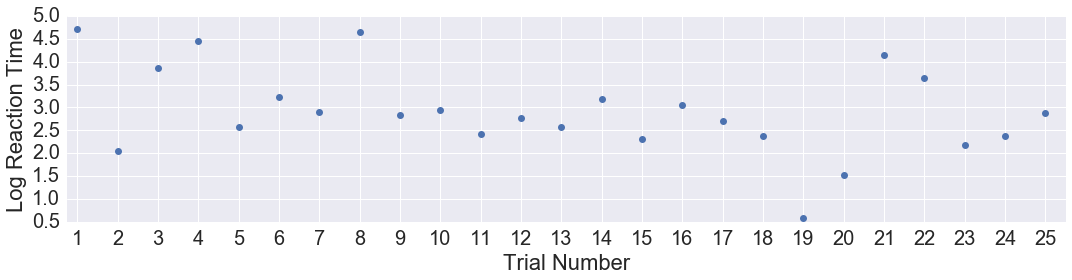

In [3]:
delta = 3.69
h = -0.38
sigg = 0.75
G = np.sqrt(sigg)*np.random.randn(N)
Q = delta + h*X + G

plt.figure(figsize=(15,4))
plt.plot(range(1,N+1),Q,'o')
plt.xlim(0.75,N+0.5)
plt.xticks(range(1,N+1))
plt.xlabel('Trial Number')
plt.ylabel('Log Reaction Time')
plt.tight_layout();

### Trial Outcome (Binary Observation)
A second observable result that we model as a function of the learning state is the binary result of a trial - did the subject do the task correctly (1) or incorrectly (0). Given the binary nature of this observation, it makes sense to represent the result of the $n^{th}$ trial with a Bernoulli probability model:

$$
P(M_n = m \mid X_n = x_n) = p_n^m(1-p_n)^{1-m}
$$

where $m \in \{0,1\}$. We now want to formulate the probability of success on the $n^{th}$ trial as a function of the learning state $X_n = x_n$ for that trial. Considering $X_n$ is a real number, we use a logistic function to map it into a probability such that as the learning state approaches infinity, the probability of success approaches one. This is accomplished with:

$$
p_n = \frac{e^{\mu+\eta x_n}}{1 + e^{\mu+\eta x_n}}
$$


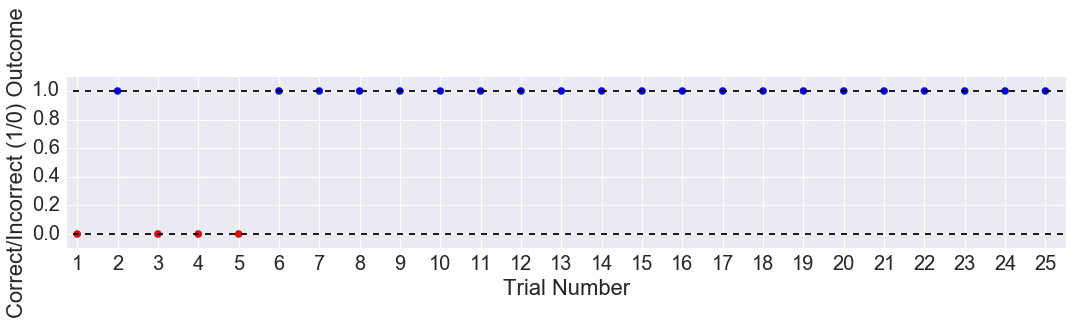

In [4]:
mu = -1.4170
eta = 1.75
p = np.exp(mu + eta*X)/(1 + np.exp(mu+eta*X))
M = np.zeros((N,))
col = []
for n in range(len(M)):
    M[n] = bern.rvs(p[n],size=1)
    if M[n] == 1: col.append('b')
    else: col.append('r')

plt.figure(figsize=(15,4))
plt.plot([0]*(N+2),'k--',[1]*(N+2),'k--')
plt.scatter(range(1,N+1),M,c=col,s=50)
plt.xlim(0.75,N+0.5)
plt.xticks(range(1,N+1))
plt.ylim([-.1,1.1])
plt.xlabel('Trial Number')
plt.ylabel('Correct/Incorrect (1/0) Outcome')
plt.tight_layout();

### Neural Spiking (Point Process)
The final observable result is the number of spikes observed during a trial. To formulate this observation mathematically, we begin by dividing each trial into $J=\frac{T}{\Delta}$ bins, where $T$ is the duration of the trial and $\Delta$, the width of the bins, is chosen such that there will be at most one spike per bin. We let $R_{n,j}=1$ if there is a spike in the corresponding bin and $0$ otherwise. We let $R_n = [R_{n,1}, \dots , R_{n,J}]$ be the spikes recorded on the $n^{th}$ trial and $R^n = [R_1,\dots,R_n]$ be the spikes observed from trial $1$ to $n$. We then represent the probability of getting a spike in a bin given the number of spikes in all of the previous trials and the locations of the spikes in preceding bins of the current trial with:

$$
P(R_{n,j} \mid X^n = x^n, R^{n-1}=r^{n-1}, R_{n,1}=r_{n,1},\dots,R_{n,j-1}=r_{n,j-1}) 
= \left(\Lambda_{n,j}\Delta\right)^{r_{n,j}}e^{-\Lambda_{n,j}\Delta}
$$

Where $\Lambda_{n,j}$ is the conditional intensity function defined in by:

$$
\log \Lambda_{n,j} = \psi + gx_n + \sum_{s=1}^S c_s r_{n,j-s}
$$

At this point there are a couple of things we can observe a number of things. First of all, we see that for a higher learning state $x_n$, there is a higher intensity function (because $g$ is positive). Thus as the learning state increases, the number of spikes increases as well. 

$$
P(R_n=r_n \mid X^n=x^n)
= \exp\left(\sum_{j=1}^{J}\log(\Lambda_{n,j})r_{n,j}-\Lambda_{n,j}\Delta \right)
$$


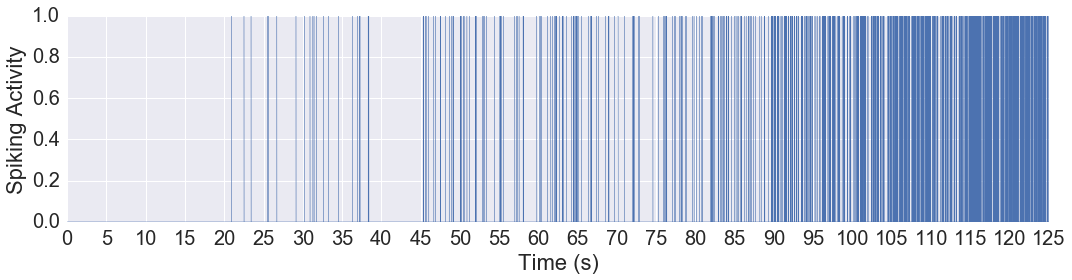

In [5]:
T = 5
Del = 0.001
J = int(T/Del)
psi = -3.5
g = 2.0
c = [-20,-5,1,3]

R = np.zeros((N,J))
for n in range(N):
    for j in range(J):
        c_sum = 0
        for s in range(len(c)):
            if(j-(s+1)>=0):
                c_sum += c[s]*R[n,j-(s+1)]
        lam_nj = np.exp(psi + g*X[n] + c_sum)
        R[n,j] = bern.rvs(lam_nj*Del*np.exp(-lam_nj*Del),size=1)

R_vec = R.reshape(N*J,1)
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,N*J/1000,1/1000),R_vec,linewidth=0.3)
plt.xlim([0,N*J/1000])
plt.xticks(range(0,130,5))
plt.xlabel('Time (s)')
plt.ylabel('Spiking Activity')
plt.tight_layout();

## *2 - Estimating Learning State Using ADMM*

Below we estimate the latent learning state variable based on the simulated observations and plot the results alongside the simulated ground truth.

In [6]:
rho = .5
max_iters = 20
verbosity = 1         

# generate an AdmmObject for the spectrotemporal pursuit problem
params = [gamma,phi,sigv,delta,h,sigg,mu,eta,psi,g,c,Del,J]
x = ssml(observations=(M,Q,R), rho=rho, params=params, max_iters=max_iters, verbosity=verbosity)

Beginning ADMM Iterations


Total runtime: 8.731813907623291 seconds
Total number of iterations: 20
Norm of differences between x and z: 0.525072115096
Norm of differences between w and z differences: 0.508805803932
Average Update Times:
x - 0.43601263761520376 seconds
w - 0.0001998305320739746 seconds
z - 2.65359878540039e-05 seconds
lambda - 2.530813217163086e-05 seconds
alpha - 1.3601779937744135e-05 seconds
---------------------------------------



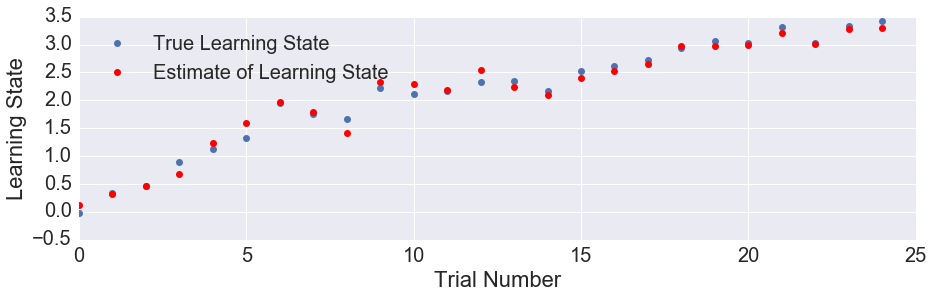

In [7]:
plt.figure(figsize=(15,4))
ns = range(N)
plt.plot(ns,X,'o',label='True Learning State')
plt.plot(ns,x,'ro',label='Estimate of Learning State')
plt.legend(loc=2)

plt.xlabel('Trial Number')
plt.ylabel('Learning State');

## *3 - Multiple Observations*

Next, we will see how the algorithm performs over mutliple independent realizations of the observation processes. First, we will create a learning state that will be used as the ground truth for each realization.

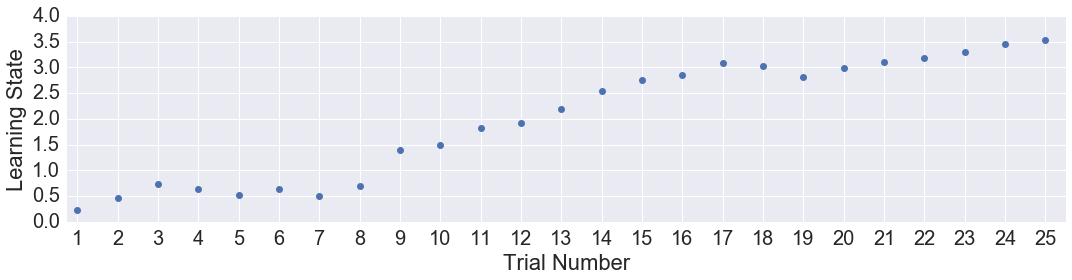

In [9]:
N = 25           # Number of trials
gamma = 0.1      # Learning rate
phi = 0.99       # Forgetting factor
sigv = 0.03      # Variance of zero mean Gaussian vector for learning state random walk
V = np.sqrt(sigv)*np.random.randn(N) # Gaussian vector for learning state random walk
X = np.zeros((N,))
X[0] = gamma + V[0]
for n in range(1,len(X)):
    X[n] = gamma + phi*X[n-1] + V[n]

plt.figure(figsize=(15,4))
plt.plot(range(1,N+1),X,'o')
plt.xlim(0.75,N+0.5)
plt.xticks(range(1,N+1))
plt.xlabel('Trial Number')
plt.ylabel('Learning State')
plt.tight_layout();

Next, we will repeatedly simulate estimations using this ground truth learning state.

In [10]:
# Number of realizations
num = 10

# Reaction time parameters
delta = 3.69
h = -0.38
sigg = 0.75
# Binary outcome parameters
mu = -1.4170
eta = 1.75
p = np.exp(mu + eta*X)/(1 + np.exp(mu+eta*X))
# Neural spiking parameters
T = 5
Del = 0.001
J = int(T/Del)
psi = -3.5
g = 2.0
c = [-20,-5,1,3]

# Store all the results
Qs = np.zeros((num,N))
Ms = np.zeros((num,N))
Rs = np.zeros((num,N,J))

for event in range(num):
    # Generate reaction times
    G = np.sqrt(sigg)*np.random.randn(N)
    Q = delta + h*X + G
    # Generate binary outcomes
    M = np.zeros((N,))
    for n in range(len(M)):
        M[n] = bern.rvs(p[n],size=1)
    # Generate spiking
    R = np.zeros((N,J))
    for n in range(N):
        for j in range(J):
            c_sum = 0
            for s in range(len(c)):
                if(j-(s+1)>=0):
                    c_sum += c[s]*R[n,j-(s+1)]
            lam_nj = np.exp(psi + g*X[n] + c_sum)
            R[n,j] = bern.rvs(lam_nj*Del*np.exp(-lam_nj*Del),size=1)
    # Store results
    Qs[event,:] = Q
    Ms[event,:] = M
    Rs[event,:,:] = R
    print('Finished %s of %s realizations'%(event+1,num))

Finished 1 of 10 realizations
Finished 2 of 10 realizations
Finished 3 of 10 realizations
Finished 4 of 10 realizations
Finished 5 of 10 realizations
Finished 6 of 10 realizations
Finished 7 of 10 realizations
Finished 8 of 10 realizations
Finished 9 of 10 realizations
Finished 10 of 10 realizations


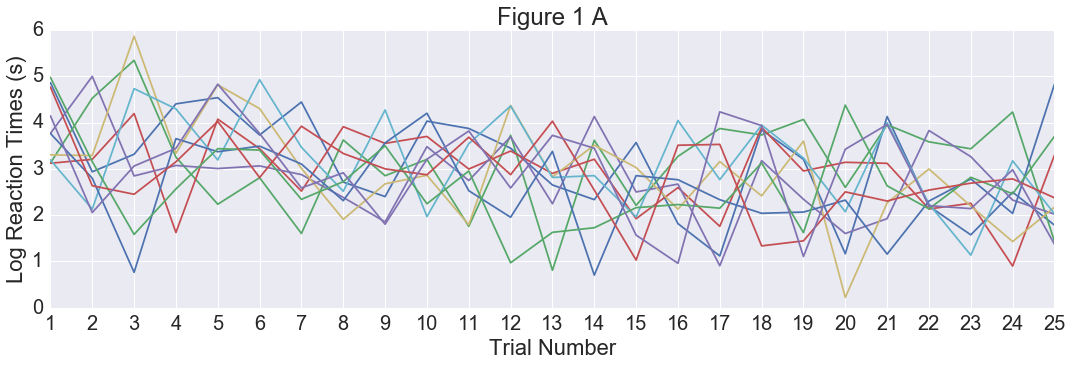

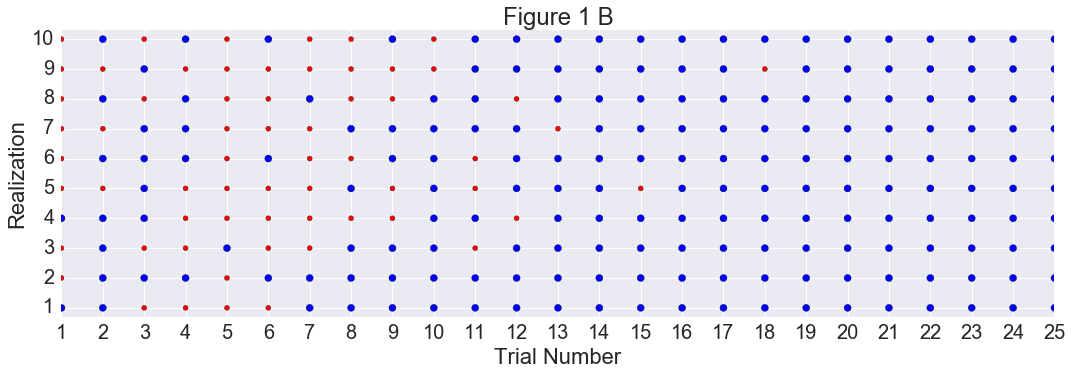

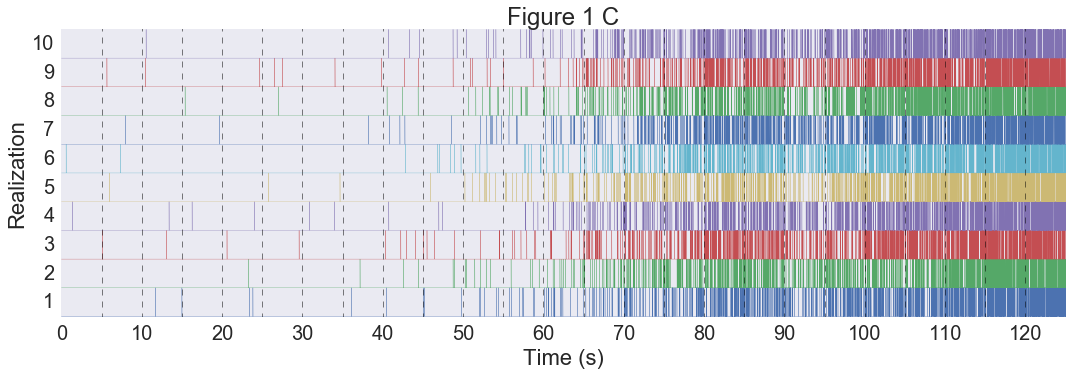

In [11]:
# Plot reaction times
plt.figure(figsize=(15,5))
for event in range(num):
    plt.plot(range(1,N+1),Qs[event,:])
plt.xlim(1,N)
plt.xticks(range(1,N+1))
plt.xlabel('Trial Number')
plt.ylabel('Log Reaction Times (s)')
plt.tight_layout();
plt.title("Figure 1 A");


# Plot binary outcomes
plt.figure(figsize=(15,5))
for event in range(num):
    M = Ms[event,:]
    col = []
    s = []
    for n in range(len(M)):
        M[n] = bern.rvs(p[n],size=1)
        if M[n] == 1: 
            col.append('b')
            s.append(50)
        else: 
            col.append('r')
            s.append(25)
    plt.scatter(range(1,N+1),[event+1]*N,c=col,s=s)
plt.xlim(1,N)
plt.xticks(range(1,N+1))
plt.ylim([1-.3,num+0.3])
plt.xlabel('Trial Number')
plt.ylabel('Realization')
plt.yticks(range(1,num+1))
plt.tight_layout();
plt.title("Figure 1 B");

# Plot neural spiking
plt.figure(figsize=(15,5))
for event in range(num):
    R_vec = Rs[event,:,:].reshape(N*J,1)
    plt.plot(np.arange(0,N*J/1000,1/1000),R_vec+event+0.5,linewidth=0.3)
for n in range(N-1):
    plt.plot([(n+1)*T,(n+1)*T],[0,num+2],'k--',linewidth=0.5)
plt.xlim([0,N*J/1000])
plt.ylim([1-.51,num+.5])
plt.xticks(range(0,130,10))
plt.xlabel('Time (s)')
plt.ylabel('Realization')
plt.yticks(range(1,num+1))
plt.grid('off')
plt.tight_layout();
plt.title("Figure 1 C");

In [12]:
rho = .5
max_iters = 20
verbosity = 0         

xs = np.zeros((num,N))
for event in range(num):
    M = Ms[event,:]
    Q = Qs[event,:]
    R = Rs[event,:,:]
    params = [gamma,phi,sigv,delta,h,sigg,mu,eta,psi,g,c,Del,J]
    x = ssml(observations=(M,Q,R), rho=rho, params=params, max_iters=max_iters, verbosity=verbosity)
    xs[event,:] = x
    print('Finished %s of %s realizations'%(event+1,num))

Finished 1 of 10 realizations
Finished 2 of 10 realizations
Finished 3 of 10 realizations
Finished 4 of 10 realizations
Finished 5 of 10 realizations
Finished 6 of 10 realizations
Finished 7 of 10 realizations
Finished 8 of 10 realizations
Finished 9 of 10 realizations
Finished 10 of 10 realizations


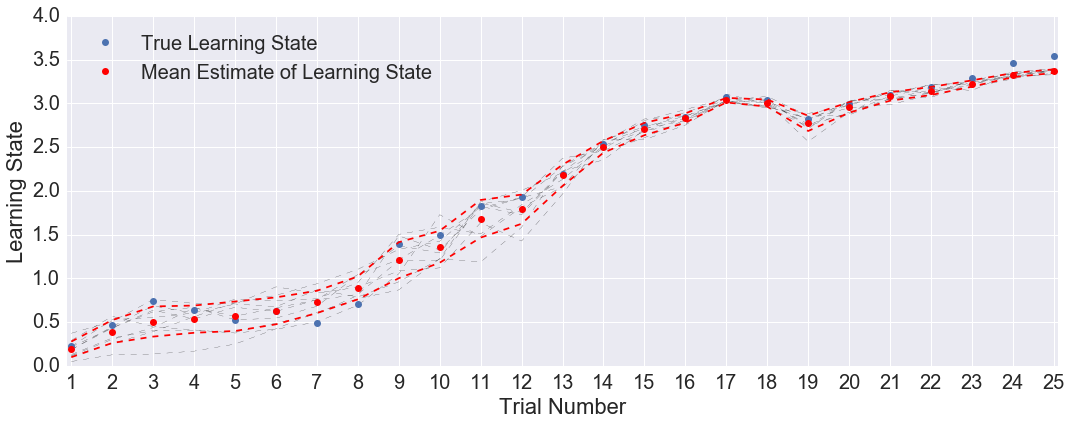

In [13]:
plt.figure(figsize=(15,6))
ns = range(1,N+1)
for event in range(num):
    plt.plot(ns,xs[event,:],'k--',linewidth=0.2)
plt.plot(ns,X,'o',label='True Learning State')
plt.plot(ns,np.mean(xs,axis=0),'ro',label='Mean Estimate of Learning State')
plt.plot(ns,np.mean(xs,axis=0)-np.std(xs,axis=0),'r--')
plt.plot(ns,np.mean(xs,axis=0)+np.std(xs,axis=0),'r--')
plt.legend(loc=2)
plt.xticks(range(1,N+1))
plt.xlim([0.9,N+0.1])
plt.xlabel('Trial Number')
plt.ylabel('Learning State')
plt.tight_layout();